In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from multiprocessing import Pool, cpu_count, current_process, shared_memory
from mpi4py import MPI
import time
import math
from tqdm.auto import trange
import cv2

In [2]:
def sequential_dotplot(seq1, seq2, block_size=1000):
    n = len(seq1)
    m = len(seq2)
    dotplot = np.zeros((n, m), dtype=np.uint8)

    for block_start in trange(0, n, block_size):
        block_end = min(block_start + block_size, n)

        # Vectorize comparisons within each block
        matches = np.equal.outer(seq1[block_start:block_end], seq2)

        dotplot[block_start:block_end, :] = np.where(matches, 1, 0)

    return dotplot

In [18]:
def multiprocessing_dotplot_worker(args):
    seq1, seq2, block_start, block_end = args
    matches = np.equal.outer(seq1[block_start:block_end], seq2)
    return np.where(matches, 1, 0)


def multiprocessing_dotplot(seq1, seq2, block_size=1000):
    n = len(seq1)
    m = len(seq2)
    dotplot = np.zeros((n, m), dtype=np.uint8)

    # Create process pool
    with Pool() as pool:
        args = [
            (seq1, seq2, block_start, min(block_start + block_size, n))
            for block_start in range(0, n, block_size)
        ]
        results = pool.map(multiprocessing_dotplot_worker, args)

    # Assign results to dotplot
    for block_start, block_result in zip(range(0, n, block_size), results):
        dotplot[block_start : block_start + block_result.shape[0], :] = block_result

    return dotplot

In [13]:
%%writefile mpi_dotplot.py
from mpi4py import MPI
import numpy as np
import pickle
import argparse
from Bio import SeqIO


def sequence_str_to_uint8(sequence):
    return np.frombuffer(sequence.encode(), dtype=np.uint8)


def merge_sequences_from_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences = np.append(sequences, record.seq)
    return "".join(sequences)


e_coli_sequence = sequence_str_to_uint8(
    merge_sequences_from_fasta("archivosParaDotplot/E_coli.fna")
)
salmonella_sequence = sequence_str_to_uint8(
    merge_sequences_from_fasta("archivosParaDotplot/Salmonella.fna")
)


def mpi_dotplot_worker(rank, size, seq1, seq2, block_size, n):
    # This function will be run by each worker process
    matches_blocks = []
    block_indices = []
    for i in range(rank, n, size * block_size):
        block_start = i
        block_end = min(i + block_size, n)
        matches = np.equal.outer(seq1[block_start:block_end], seq2)
        matches_blocks.append(np.where(matches, 1, 0))
        block_indices.append(block_start)
    return matches_blocks, block_indices


def mpi_dotplot(seq1, seq2, block_size=1000):
    n = len(seq1)
    m = len(seq2)

    # Initialize MPI
    comm = MPI.COMM_WORLD
    size = comm.Get_size()  # Total number of processes
    rank = comm.Get_rank()  # Rank of this process

    results, indices = mpi_dotplot_worker(rank, size, seq1, seq2, block_size, n)
    all_results = comm.gather(results, root=0)
    all_indices = comm.gather(indices, root=0)

    if rank == 0:
        # Only the root process creates the dotplot
        dotplot = np.zeros((n, m), dtype=np.uint8)
        for res, ind in zip(all_results, all_indices):
            for block, start in zip(res, ind):
                dotplot[start : start + block.shape[0], :] = block

        # Save the dotplot to a pickle file
        with open("dotplot.pkl", "wb") as f:
            pickle.dump(dotplot, f)

        return dotplot


if __name__ == "__main__":
    # Parse command-line arguments
    parser = argparse.ArgumentParser(
        description="Perform a dotplot analysis on two DNA sequences."
    )
    parser.add_argument(
        "--file1", type=str, required=True, help="Path to the first fasta file."
    )
    parser.add_argument(
        "--file2", type=str, required=True, help="Path to the second fasta file."
    )
    parser.add_argument(
        "--test-size",
        type=int,
        default=15000,
        help="Size of the sequence subset for testing.",
    )
    args = parser.parse_args()

    # Load sequences from files
    seq1 = sequence_str_to_uint8(merge_sequences_from_fasta(args.file1))
    seq2 = sequence_str_to_uint8(merge_sequences_from_fasta(args.file2))

    # Perform dotplot analysis
    dotplot = mpi_dotplot(seq1[: args.test_size], seq2[: args.test_size])


Overwriting mpi_dotplot.py


In [ ]:
start = time.time()
dotplot_mult = multiprocessing_dotplot(
    e_coli_sequence[:test_size], salmonella_sequence[:test_size]
)
end = time.time()
multiprocessing_time = end - start
print(f"Tiempo de ejecución con multiprocessing: {multiprocessing_time}")

OSError: [Errno 12] Cannot allocate memory

In [6]:
def sequence_str_to_uint8(sequence):
    return np.frombuffer(sequence.encode(), dtype=np.uint8)


def merge_sequences_from_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences = np.append(sequences, record.seq)
    return "".join(sequences)


e_coli_sequence = sequence_str_to_uint8(
    merge_sequences_from_fasta("archivosParaDotplot/E_coli.fna")
)
salmonella_sequence = sequence_str_to_uint8(
    merge_sequences_from_fasta("archivosParaDotplot/Salmonella.fna")
)

print(e_coli_sequence.shape, salmonella_sequence.shape)

(4641652,) (4951383,)


In [23]:
test_size = 150000

In [24]:
start = time.time()
dotplot_sequential = sequential_dotplot(
    e_coli_sequence[:test_size], salmonella_sequence[:test_size]
)
end = time.time()
sequential_time = end - start
print(f"Tiempo de ejecución secuencial: {sequential_time}")

  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
def plot_dotplot(dotplot, title="Dotplot"):
    # draw dotplot
    plt.figure(figsize=(10, 10))
    plt.imshow(dotplot, cmap="Greys", aspect="auto")
    plt.title(title)
    plt.show()

In [ ]:
plot_dotplot(dotplot_sequential[:300, :300])

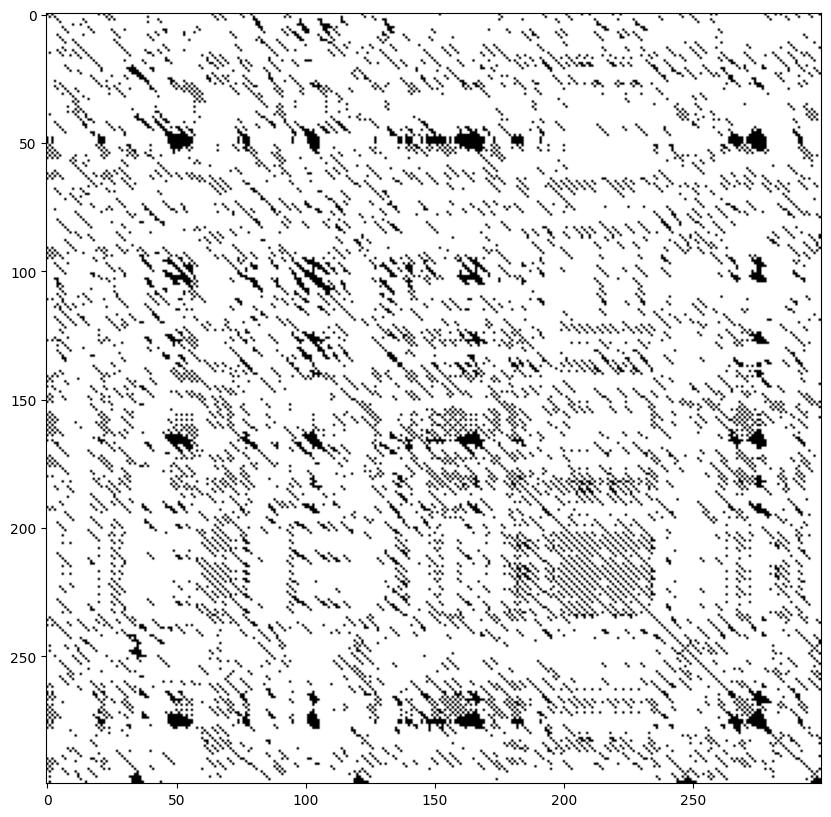

In [ ]:
# Creamos un kernel que pondrá más peso en los píxeles en la diagonal
kernel_size = 5
kernel = np.zeros((kernel_size, kernel_size))
np.fill_diagonal(kernel, 1)

# Normalizamos el kernel para que la suma de todos sus elementos sea 1
kernel /= np.sum(kernel)

# Usamos la función filter2D de OpenCV para aplicar el kernel al dotplot
filtered_dotplot = cv2.filter2D(
    dotplot_sequential[:300, :300].astype(np.uint8), -1, kernel
)

# Mostramos el dotplot filtrado
plt.figure(figsize=(10, 10))
plt.imshow(filtered_dotplot, cmap="Greys", aspect="auto")
plt.show()

In [26]:
start = time.time()
dotplot_mult = multiprocessing_dotplot(
    e_coli_sequence[:test_size], salmonella_sequence[:test_size]
)
end = time.time()
multiprocessing_time = end - start
print(f"Tiempo de ejecución con multiprocessing: {multiprocessing_time}")

OSError: [Errno 12] Cannot allocate memory

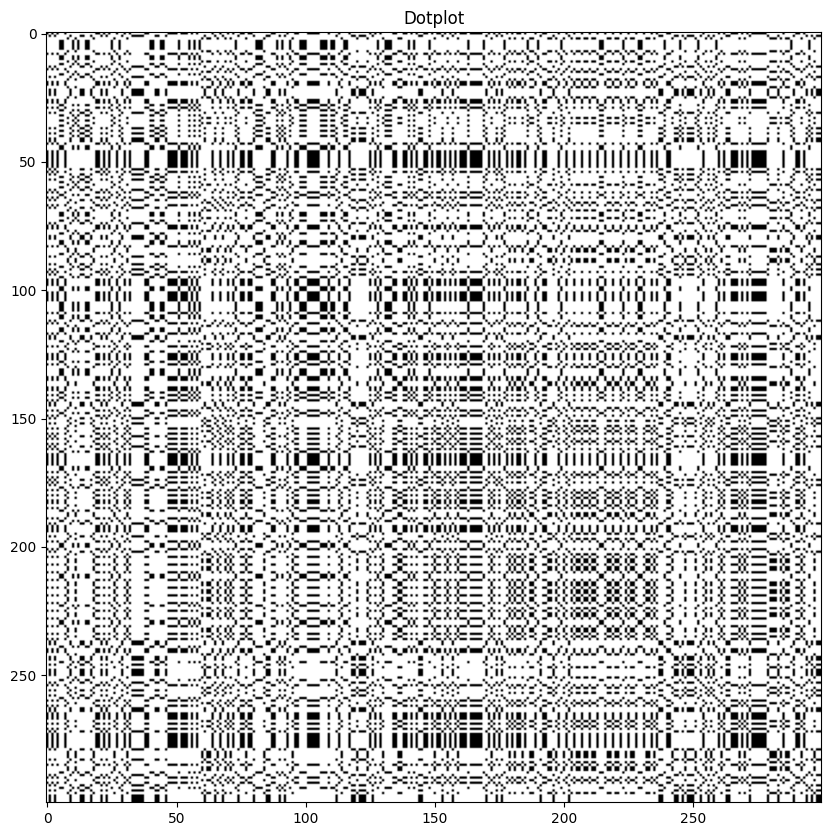

In [13]:
plot_dotplot(dotplot_mult[:300, :300])

In [14]:
!mpirun -n 4 python3 mpi_dotplot.py --file1=archivosParaDotplot/E_coli.fna --file2=archivosParaDotplot/Salmonella.fna --test-size=15000

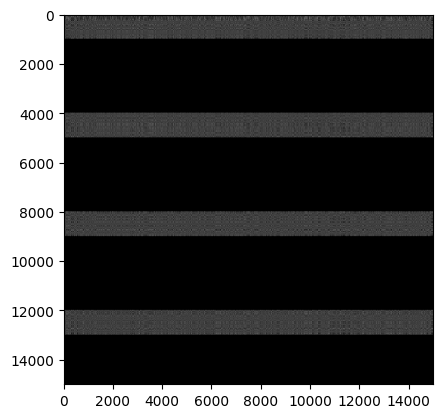

In [15]:
import pickle
import matplotlib.pyplot as plt

# Load the dotplot from the file
with open("dotplot.pkl", "rb") as f:
    dotplot = pickle.load(f)

# Visualize the dotplot
plt.imshow(dotplot, cmap="gray")
plt.show()